![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [59]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [60]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change current working directory to project folder (2 marks)

In [62]:
project_path = '/content/drive/My Drive/GL dataset/'

In [63]:
data_path = project_path + 'Aligned Face Dataset from Pinterest.zip'

### Extract the zip file (3 marks)
- Extract Aligned Face Dataset from Pinterest.zip

In [58]:
from zipfile import ZipFile
with ZipFile(data_path, 'r') as z:
  z.extractall()
print("Data zip extraction done!")

Data zip extraction done!


### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [65]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

### Define function to load image
- Define a function to load image from the metadata

In [66]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image (3 marks)
- Load one image using the function "load_image"

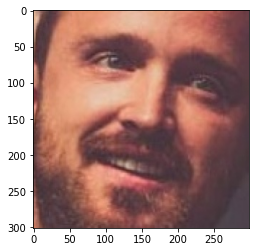

In [68]:
plt.imshow(load_image('/content/pins/PINS/pins_Aaron Paul/Aaron Paul0_262.jpg'))


### VGG Face model
- Here we are giving you the predefined model for VGG face

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model (3 marks)
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [35]:
model = vgg_face()
WEIGHTS_FILE = project_path + 'vgg_face_weights.h5'
model.load_weights(WEIGHTS_FILE)

### Get vgg_face_descriptor

In [36]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [37]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images (8 marks)
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [40]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
  img_path = m.image_path()
  img = load_image(m.image_path())

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)
  img = cv2.resize(img, dsize = (224,224))

  embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [41]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

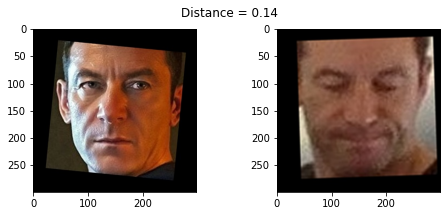

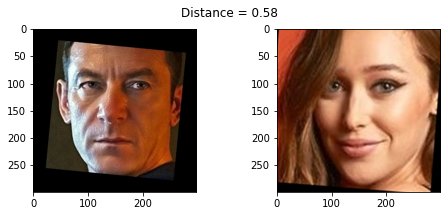

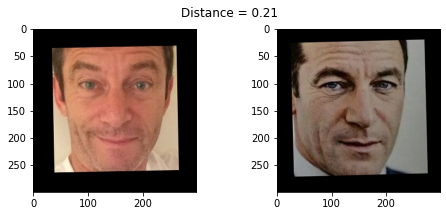

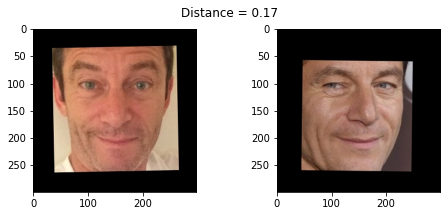

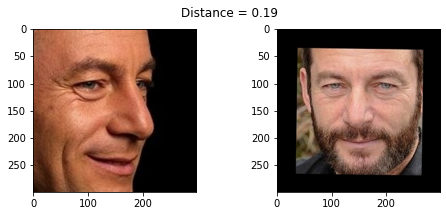

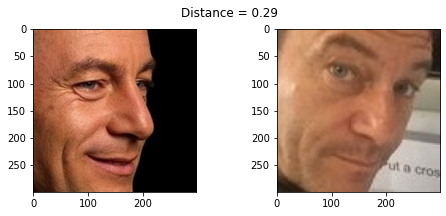

In [42]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets (8 marks)
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [43]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities

X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]

### Encode the Labels (4 marks)
- Encode the targets
- Use LabelEncoder

In [44]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.fit(y_test)
y_train_le = label_encoder.transform(y_train)
y_test_le = label_encoder.transform(y_test)

### Standardize the feature values (4 marks)
- Scale the features using StandardScaler

In [45]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

### Reduce dimensions using PCA (4 marks)
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
pca.fit(X_train_s)
pca.fit(X_test_s)

X_train_pca = pca.transform(X_train_s)
X_test_pca = pca.transform(X_test_s)

### Build a Classifier (4 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [48]:
from sklearn.svm import SVC

model_svc = SVC()
model_svc.fit(X_train_pca , y_train_le)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
model_svc.score(X_test_pca, y_test_le)

0.9590643274853801

### Test results (2 mark)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

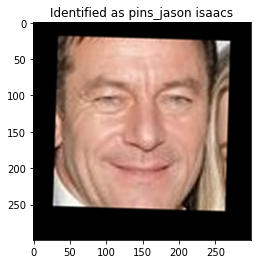

In [54]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = model_svc.predict(X_test_pca)
example_identity = label_encoder.inverse_transform(example_prediction)[10]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

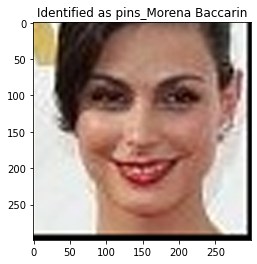

In [56]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 150

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = model_svc.predict(X_test_pca)
example_identity = label_encoder.inverse_transform(example_prediction)[150]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');